# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [71]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random

**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

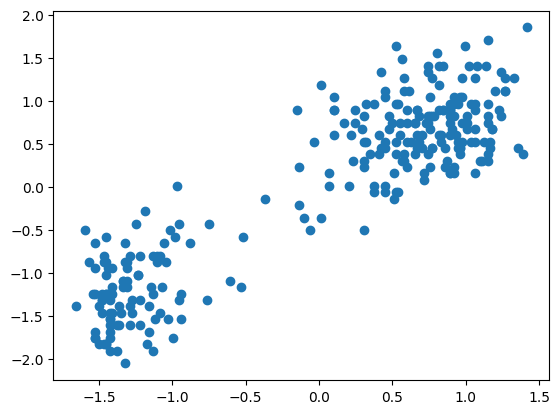

In [57]:
# Load the "Old Faithful" dataset from the Seaborn library
df = seaborn.load_dataset('geyser')
X = df[['duration', 'waiting']]
N, D = X. shape


# Standardize data to avoid numerical instabilities

# # # # # # # # #
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
# # # # # # # # #


# Show data

# # # # # # # # #
plt.scatter(X_scaled.iloc[:,0],X_scaled.iloc[:,1])
# # # # # # # # #


----- Votre réponse ici -----








**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [92]:
def log_likelihood(X, mean, cov, pk): # Fill in the appropriate arguments

    # # # # # # # # #
    K = len(mean)
    log_like = 0
    y = np.zeros((X.shape[0],k))
    for j in range(k):
        mvn = ss.multivariate_normal(mean= mean[j], cov=cov[j])
        y[:,j] = pk[j]*mvn.pdf(X)
    log_like = np.sum(np.log(np.sum(y, axis = 1)))
    return log_like
    # # # # # # # # #

In [93]:
k = 2
cov = [ np.eye(D) for _ in range (k)]
mean = [[random.uniform(-2, 2), random.uniform(-2, 2)] for _ in range(k)]
weights = [random.random() for _ in range(k)]
pk = [weights[j]/sum(weights) for j in range(k)]
log_likelihood(X_scaled, mean=mean, cov=cov, pk=pk)

-831.9975338812601

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [98]:
def EM_algorithm_v1(X, K, Niter):
    N, D = X.shape
    
    # Initialize parameters

    # # # # # # # # #
    mean = X.iloc[:K].values
    cov = [ np.eye(D) for _ in range (K)]
    
    pk = [1/K for i in range (K)]
    # # # # # # # # #

    for i in range(0,Niter):
        # E-STEP
        
        # # # # # # # # #
        rn = np.zeros((N,K))
        for j in range(K):
            mvn = ss.multivariate_normal(mean= mean[j], cov=cov[j])
            rn[:,j] = pk[j]*mvn.pdf(X)
        rn = [rn[i]/np.sum(rn[i]) for i in range(N)]
        print(rn)
        # # # # # # # # #
        
        # M-STEP
        
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #
    return None

In [99]:
EM_algorithm_v1(X_scaled, 2, 1)

[array([0.95003499, 0.04996501]), array([0.04996501, 0.95003499]), array([0.86944713, 0.13055287]), array([0.23339542, 0.76660458]), array([0.99365457, 0.00634543]), array([0.21290671, 0.78709329]), array([0.99664031, 0.00335969]), array([0.97724064, 0.02275936]), array([0.04131075, 0.95868925]), array([0.99183635, 0.00816365]), array([0.05218269, 0.94781731]), array([0.98310359, 0.01689641]), array([0.9744566, 0.0255434]), array([0.01861749, 0.98138251]), array([0.99339778, 0.00660222]), array([0.06251806, 0.93748194]), array([0.12692679, 0.87307321]), array([0.99497439, 0.00502561]), array([0.02948155, 0.97051845]), array([0.97909428, 0.02090572]), array([0.0338145, 0.9661855]), array([0.01861749, 0.98138251]), array([0.930951, 0.069049]), array([0.70022498, 0.29977502]), array([0.97235447, 0.02764553]), array([0.97035101, 0.02964899]), array([0.07057996, 0.92942004]), array([0.96112364, 0.03887636]), array([0.95914903, 0.04085097]), array([0.98370379, 0.01629621]), array([0.95694902

**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

In [ ]:
K = 2
Niter = 50

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #

----- Votre réponse ici -----

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [ ]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)

    # # # # # # # # #
    # YOUR CODE HERE #
    # # # # # # # # #

    for i in range(0,Niter):
        # E-STEP
        
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #
        
        # M-STEP
        
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #
        
    return # YOUR CODE HERE #

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

In [ ]:
K = 3

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance de le modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

In [ ]:
# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.


----- Votre réponse ici -----